In [3]:
import pandas as pd
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import train_test_split

df = pd.read_csv('cars.csv')


#CLEANING NORMALIZING

In [4]:
# -------------------------------------------------------------------
# 1. CLEANING (your rules)
# -------------------------------------------------------------------
df = df.drop(columns=['seller_name', 'seller_rating'])
df = df.dropna(subset=['driver_rating', 'mileage'])

df['exterior_color']  = df['exterior_color'].fillna('Unknown')
df['engine']          = df['engine'].fillna('Unknown')
df['transmission']    = df['transmission'].fillna('Unknown')
df['interior_color']  = df['interior_color'].fillna('Unknown')

df['accidents_or_damage_missing'] = df['accidents_or_damage'].isna().astype(int)
df['accidents_or_damage'] = df['accidents_or_damage'].fillna(0)

df['one_owner_missing'] = df['one_owner'].isna().astype(int)
df['one_owner'] = df['one_owner'].fillna(1)

df['personal_use_only_missing'] = df['personal_use_only'].isna().astype(int)
df['personal_use_only'] = df['personal_use_only'].fillna(1)

df['drivetrain'] = df['drivetrain'].fillna('Missing')
df['fuel_type']  = df['fuel_type'].fillna('Missing')
df['mpg']        = df['mpg'].fillna('Missing')

df['price_drop'] = df['price_drop'].fillna(0)
df['driver_total_rating'] = df['driver_rating'] * df['driver_reviews_num']

# -------------------------------------------------------------------
# 2. TARGET AND FEATURES
# -------------------------------------------------------------------
print("Columns at this point:", df.columns.tolist())  # sanity check

df = df[df['price'] <= 75000]

# optional: downsample to make everything faster (e.g. 100k rows)
# df = df.sample(n=100000, random_state=42)

y = df['price']               # if this line errors, price is really gone
X = df.drop(columns=['price'])


# -------------------------------------------------------------------
# 3. ENCODING
#    - low-cardinality categoricals: one-hot
#    - high-cardinality: integer codes
# -------------------------------------------------------------------
cat_cols = X.select_dtypes(include=['object']).columns

threshold = 50
low_card = [c for c in cat_cols if X[c].nunique() <= threshold]
high_card = [c for c in cat_cols if c not in low_card]

for c in high_card:
    X[c] = X[c].astype('category').cat.codes

X = pd.get_dummies(X, columns=low_card, drop_first=True)

print("Final feature shape:", X.shape)

# -------------------------------------------------------------------
# 4. TRAIN / VAL / TEST SPLIT (70 / 20 / 10)
# -------------------------------------------------------------------
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=1/3, random_state=42
)

print("Train:", X_train.shape)
print("Val:",   X_val.shape)
print("Test:",  X_test.shape)

# -------------------------------------------------------------------
# 5. STANDARDIZATION (for MLP)
# -------------------------------------------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)


Columns at this point: ['manufacturer', 'model', 'year', 'mileage', 'engine', 'transmission', 'drivetrain', 'fuel_type', 'mpg', 'exterior_color', 'interior_color', 'accidents_or_damage', 'one_owner', 'personal_use_only', 'driver_rating', 'driver_reviews_num', 'price_drop', 'price', 'accidents_or_damage_missing', 'one_owner_missing', 'personal_use_only_missing', 'driver_total_rating']
Final feature shape: (711452, 114)
Train: (498016, 114)
Val: (142290, 114)
Test: (71146, 114)


#GRADIENT BOOSTING

Training time: 149.30 s
--- Train ---
MAE : 4,264.92
RMSE: 5,936.00
R^2 : 0.815

--- Validation ---
MAE : 4,276.63
RMSE: 5,953.22
R^2 : 0.814

--- Test ---
MAE : 4,273.85
RMSE: 5,960.29
R^2 : 0.814

Test prediction time for 71146 samples: 179.11 ms
Per-sample prediction time: 0.0025 ms


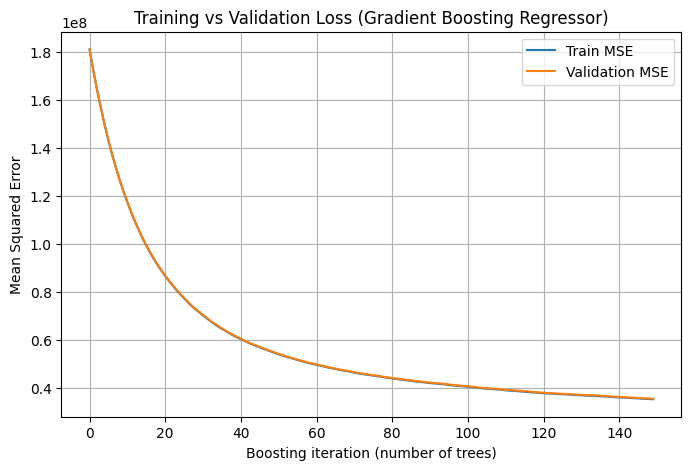

In [5]:
# =============================
# Gradient Boosting for Car Price
# =============================

import pandas as pd
import numpy as np

from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# ------------------------------------------------------
# 7. Gradient Boosting model
# ------------------------------------------------------
from sklearn.ensemble import GradientBoostingRegressor
import time
import numpy as np
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score
)

gbr = GradientBoostingRegressor(
    n_estimators=150,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

# Train with timing
start = time.perf_counter()
gbr.fit(X_train, y_train)
train_time_s = time.perf_counter() - start
print(f"Training time: {train_time_s:.2f} s")

# ------------------------------------------------------
# 8. Evaluation helpers
# ------------------------------------------------------
def evaluate(split_name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"--- {split_name} ---")
    print(f"MAE : {mae:,.2f}")
    print(f"RMSE: {rmse:,.2f}")
    print(f"R^2 : {r2:.3f}")
    print()


#Train
evaluate("Train", y_train, gbr.predict(X_train))

# Validation
y_val_pred = gbr.predict(X_val)
evaluate("Validation", y_val, y_val_pred)

# Test with timing
start = time.perf_counter()
y_test_pred = gbr.predict(X_test)
test_time_s = time.perf_counter() - start

evaluate("Test", y_test, y_test_pred)
print(f"Test prediction time for {len(X_test)} samples: {test_time_s*1000:.2f} ms")
print(f"Per-sample prediction time: {(test_time_s*1000)/len(X_test):.4f} ms")


train_mse = []
val_mse = []

for y_pred_train, y_pred_val in zip(
    gbr.staged_predict(X_train),
    gbr.staged_predict(X_val)
):
    train_mse.append(mean_squared_error(y_train, y_pred_train))
    val_mse.append(mean_squared_error(y_val,   y_pred_val))

plt.figure(figsize=(8, 5))
plt.plot(train_mse, label="Train MSE")
plt.plot(val_mse,   label="Validation MSE")
plt.xlabel("Boosting iteration (number of trees)")
plt.ylabel("Mean Squared Error")
plt.title("Training vs Validation Loss (Gradient Boosting Regressor)")
plt.legend()
plt.grid(True)
plt.show()



#Mutliple Linear Regression

In [6]:
# =============================
# Multiple Linear Regression for Car Price
# =============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# -------------------------------------------------------------------
# 7. MULTIPLE LINEAR REGRESSION MODEL
# -------------------------------------------------------------------
mlr = LinearRegression()

# Train
mlr.fit(X_train_scaled, y_train)

# Predictions
y_train_pred = mlr.predict(X_train_scaled)
y_val_pred   = mlr.predict(X_val_scaled)
y_test_pred  = mlr.predict(X_test_scaled)


# -------------------------------------------------------------------
# 8. EVALUATION
# -------------------------------------------------------------------
def evaluate(split_name, y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2   = r2_score(y_true, y_pred)
    print(f"--- {split_name} ---")
    print(f"MAE : {mae:,.2f}")
    print(f"RMSE: {rmse:,.2f}")
    print(f"R^2 : {r2:.3f}")
    print()

evaluate("Train (MLR)", y_train, y_train_pred)
evaluate("Validation (MLR)", y_val, y_val_pred)
evaluate("Test (MLR)", y_test, y_test_pred)




--- Train (MLR) ---
MAE : 5,411.93
RMSE: 7,447.19
R^2 : 0.709

--- Validation (MLR) ---
MAE : 35,863,679,839.83
RMSE: 8,101,852,075,124.02
R^2 : -343927670206648512.000

--- Test (MLR) ---
MAE : 4,435,169,683.40
RMSE: 1,183,000,571,266.28
R^2 : -7334024731084566.000



# Random Forest and MLP


--- RANDOM FOREST ---
Train R2: 0.9927037749973407
Train RMSE: 1179.6880936538535
Train MAE: 786.6980687263813
Val   R2: 0.948393505553849
Val   RMSE: 3138.361230714295
Val   MAE: 2100.960224844852
Val   MAPE (%): 26.72591734168818
Test  R2: 0.94774164818868
Test  RMSE: 3157.8509201979186
Test  MAE: 2122.1501258209505
Test  MedAE: 1507.6062499999994
Test  MAPE (%): 8.920857494019526
RF training time (ms): 49901.17858396843
RF prediction time (ms) - train: 3578.7819999968633
RF prediction time (ms) - val:   1013.901791011449
RF prediction time (ms) - test:  516.0678339889273


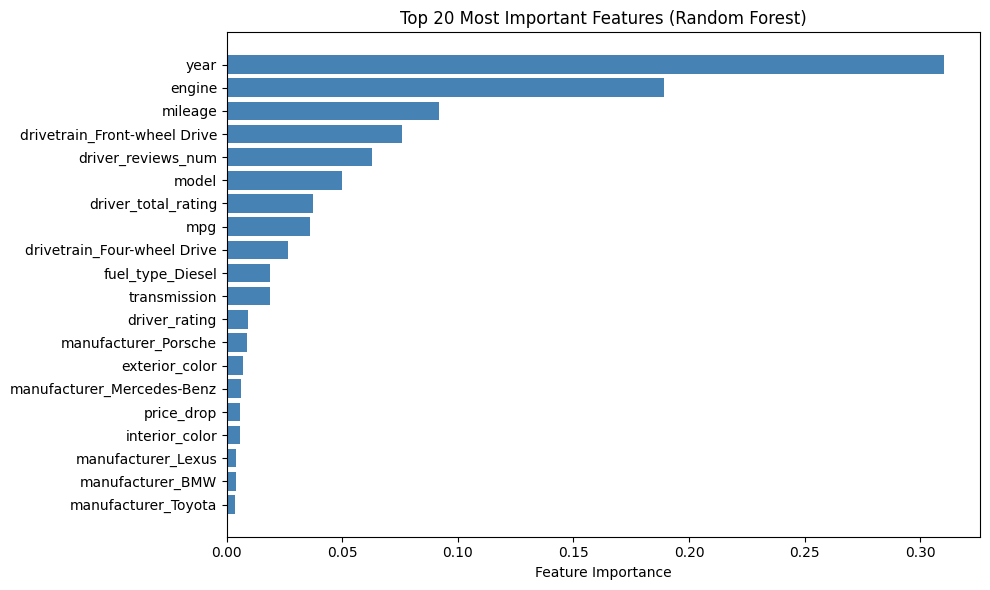

Epoch 1: train_RMSE=5580.9657, val_RMSE=5614.3774
Epoch 2: train_RMSE=5293.3947, val_RMSE=5302.9335
Epoch 3: train_RMSE=5077.8317, val_RMSE=5102.5500
Epoch 4: train_RMSE=4866.3914, val_RMSE=4900.9397
Epoch 5: train_RMSE=4678.1789, val_RMSE=4753.6764
Epoch 6: train_RMSE=4586.6383, val_RMSE=4619.6806
Epoch 7: train_RMSE=4507.1438, val_RMSE=4528.2086
Epoch 8: train_RMSE=4400.4638, val_RMSE=4540.0652
Epoch 9: train_RMSE=4317.9353, val_RMSE=4380.3133
Epoch 10: train_RMSE=4303.5401, val_RMSE=4327.4244
Epoch 11: train_RMSE=4226.3343, val_RMSE=4332.6514
Epoch 12: train_RMSE=4181.0682, val_RMSE=4254.7925
Epoch 13: train_RMSE=4150.9723, val_RMSE=4222.5446
Epoch 14: train_RMSE=4121.5856, val_RMSE=4204.0210
Epoch 15: train_RMSE=4093.4278, val_RMSE=4175.7240
Epoch 16: train_RMSE=4068.6451, val_RMSE=4153.7377
Epoch 17: train_RMSE=4044.2364, val_RMSE=4132.1611
Epoch 18: train_RMSE=4022.8590, val_RMSE=4114.6844
Epoch 19: train_RMSE=4003.8155, val_RMSE=4097.8234
Epoch 20: train_RMSE=3987.9741, val_RMSE

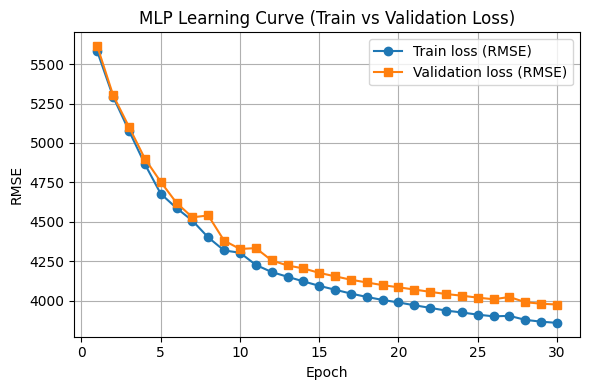


--- SUMMARY: Random Forest vs MLP (Test set) ---
Random Forest: R2 = 0.9477, RMSE = 3157.8509, MAE = 2122.1501, MedAE = 1507.6062, MAPE = 8.92%
MLP:           R2 = 0.9170, RMSE = 3978.7330, MAE = 2718.5265, MedAE = 1903.3388, MAPE = 10.64%

Training times (ms):
RandomForest: 49901.18 ms
MLP: 396896.16 ms

Prediction times on test set (ms):
RandomForest: 516.0678339889273
MLP:          171.6491670231335


In [7]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    median_absolute_error
)
from sklearn.exceptions import ConvergenceWarning
import warnings

warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# helper: regression metrics
def regression_metrics(y_true, y_pred):
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    medae = median_absolute_error(y_true, y_pred)

    # MAPE: ignore zeros in y_true to avoid division-by-zero
    y_true_nonzero = y_true[y_true != 0]
    y_pred_nonzero = y_pred[y_true != 0]
    if len(y_true_nonzero) > 0:
        mape = np.mean(np.abs((y_true_nonzero - y_pred_nonzero) / y_true_nonzero)) * 100
    else:
        mape = np.nan

    return {
        "R2": r2_score(y_true, y_pred),
        "RMSE": rmse,
        "MAE": mae,
        "MedAE": medae,
        "MAPE": mape
    }

train_times_ms = {}
pred_times_ms  = {}

# -------------------------------------------------------------------
# 6. RANDOM FOREST
# -------------------------------------------------------------------
rf = RandomForestRegressor(
    n_estimators=80,
    max_depth=50,
    random_state=42,
    n_jobs=-1
)

# training time
t0 = time.perf_counter()
rf.fit(X_train, y_train)
t1 = time.perf_counter()
train_times_ms["RandomForest"] = (t1 - t0) * 1000.0

# prediction times
t0 = time.perf_counter()
y_train_rf = rf.predict(X_train)
t1 = time.perf_counter()
pred_times_ms["RandomForest_train"] = (t1 - t0) * 1000.0

t0 = time.perf_counter()
y_val_rf   = rf.predict(X_val)
t1 = time.perf_counter()
pred_times_ms["RandomForest_val"] = (t1 - t0) * 1000.0

t0 = time.perf_counter()
y_test_rf = rf.predict(X_test)
t1 = time.perf_counter()
pred_times_ms["RandomForest_test"] = (t1 - t0) * 1000.0

# metrics
rf_train_metrics = regression_metrics(y_train, y_train_rf)
rf_val_metrics   = regression_metrics(y_val,   y_val_rf)
rf_test_metrics  = regression_metrics(y_test,  y_test_rf)

print("\n--- RANDOM FOREST ---")

# TRAIN: R2, RMSE, MAE
print("Train R2:",   rf_train_metrics["R2"])
print("Train RMSE:", rf_train_metrics["RMSE"])
print("Train MAE:",  rf_train_metrics["MAE"])

# VALIDATION: R2, RMSE, MAE, MAPE
print("Val   R2:",   rf_val_metrics["R2"])
print("Val   RMSE:", rf_val_metrics["RMSE"])
print("Val   MAE:",  rf_val_metrics["MAE"])
print("Val   MAPE (%):", rf_val_metrics["MAPE"])

# TEST: full set
print("Test  R2:",    rf_test_metrics["R2"])
print("Test  RMSE:",  rf_test_metrics["RMSE"])
print("Test  MAE:",   rf_test_metrics["MAE"])
print("Test  MedAE:", rf_test_metrics["MedAE"])
print("Test  MAPE (%):", rf_test_metrics["MAPE"])

print("RF training time (ms):", train_times_ms["RandomForest"])
print("RF prediction time (ms) - train:", pred_times_ms["RandomForest_train"])
print("RF prediction time (ms) - val:  ", pred_times_ms["RandomForest_val"])
print("RF prediction time (ms) - test: ", pred_times_ms["RandomForest_test"])

# Random Forest feature importance chart
# ---- Improved Feature Importance Plot (Top N Only) ----

importances = rf.feature_importances_
feature_names = X_train.columns

# sort by importance
idx_sorted = np.argsort(importances)[::-1]

# choose top N features (recommended: 15–25)
N = 20
top_features = feature_names[idx_sorted][:N]
top_importances = importances[idx_sorted][:N]

plt.figure(figsize=(10, 6))
y_pos = np.arange(N)
plt.barh(y_pos, top_importances, color="steelblue")
plt.yticks(y_pos, top_features)
plt.xlabel("Feature Importance")
plt.title(f"Top {N} Most Important Features (Random Forest)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# -------------------------------------------------------------------
# 7. MLP REGRESSOR
# -------------------------------------------------------------------

mlp = MLPRegressor(
    hidden_layer_sizes=(256, 128, 64),
    activation="relu",
    solver="adam",
    learning_rate="adaptive",
    max_iter=1,          # 1 iteration per .fit call
    warm_start=True,     # keep weights between .fit calls
    early_stopping=False,
    random_state=42
)

n_epochs = 30

mlp_train_losses = []
mlp_val_losses   = []

# training time for full MLP training (all epochs)
t0 = time.perf_counter()

for epoch in range(1, n_epochs + 1):
    # one "epoch" of training
    mlp.fit(X_train_scaled, y_train)

    # predictions for this epoch
    y_train_epoch = mlp.predict(X_train_scaled)
    y_val_epoch   = mlp.predict(X_val_scaled)

    # use RMSE as the loss for plotting
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_epoch))
    val_rmse   = np.sqrt(mean_squared_error(y_val,   y_val_epoch))

    mlp_train_losses.append(train_rmse)
    mlp_val_losses.append(val_rmse)

    print(f"Epoch {epoch}: train_RMSE={train_rmse:.4f}, val_RMSE={val_rmse:.4f}")

t1 = time.perf_counter()
train_times_ms["MLP"] = (t1 - t0) * 1000.0

# final predictions (after last epoch) for metrics
y_train_nn = mlp.predict(X_train_scaled)
y_val_nn   = mlp.predict(X_val_scaled)

t0 = time.perf_counter()
y_test_nn = mlp.predict(X_test_scaled)
t1 = time.perf_counter()
pred_times_ms["MLP_test"] = (t1 - t0) * 1000.0

# (re)compute the other prediction times if you still want them
t0 = time.perf_counter()
_ = mlp.predict(X_train_scaled)
t1 = time.perf_counter()
pred_times_ms["MLP_train"] = (t1 - t0) * 1000.0

t0 = time.perf_counter()
_ = mlp.predict(X_val_scaled)
t1 = time.perf_counter()
pred_times_ms["MLP_val"] = (t1 - t0) * 1000.0

# metrics using your regression_metrics helper
mlp_train_metrics = regression_metrics(y_train, y_train_nn)
mlp_val_metrics   = regression_metrics(y_val,   y_val_nn)
mlp_test_metrics  = regression_metrics(y_test,  y_test_nn)

print("\n--- MLP ---")
print("Train R2:",   mlp_train_metrics["R2"])
print("Train RMSE:", mlp_train_metrics["RMSE"])
print("Train MAE:",  mlp_train_metrics["MAE"])

print("Val   R2:",   mlp_val_metrics["R2"])
print("Val   RMSE:", mlp_val_metrics["RMSE"])
print("Val   MAE:",  mlp_val_metrics["MAE"])
print("Val   MAPE (%):", mlp_val_metrics["MAPE"])

print("Test  R2:",    mlp_test_metrics["R2"])
print("Test  RMSE:",  mlp_test_metrics["RMSE"])
print("Test  MAE:",   mlp_test_metrics["MAE"])
print("Test  MedAE:", mlp_test_metrics["MedAE"])
print("Test  MAPE (%):", mlp_test_metrics["MAPE"])

print("MLP training time (ms):", train_times_ms["MLP"])
print("MLP prediction time (ms) - train:", pred_times_ms["MLP_train"])
print("MLP prediction time (ms) - val:  ", pred_times_ms["MLP_val"])
print("MLP prediction time (ms) - test: ", pred_times_ms["MLP_test"])

# MLP learning curve (Train vs Validation RMSE)
epochs = np.arange(1, n_epochs + 1)
plt.figure(figsize=(6, 4))
plt.plot(epochs, mlp_train_losses, marker="o", label="Train loss (RMSE)")
plt.plot(epochs, mlp_val_losses,   marker="s", label="Validation loss (RMSE)")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("MLP Learning Curve (Train vs Validation Loss)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------------------------------------------------
# 8. Summary of key metrics and times (Test set)
# -------------------------------------------------------------------
print("\n--- SUMMARY: Random Forest vs MLP (Test set) ---")
print("Random Forest: R2 = {:.4f}, RMSE = {:.4f}, MAE = {:.4f}, MedAE = {:.4f}, MAPE = {:.2f}%".format(
    rf_test_metrics["R2"],
    rf_test_metrics["RMSE"],
    rf_test_metrics["MAE"],
    rf_test_metrics["MedAE"],
    rf_test_metrics["MAPE"]
))
print("MLP:           R2 = {:.4f}, RMSE = {:.4f}, MAE = {:.4f}, MedAE = {:.4f}, MAPE = {:.2f}%".format(
    mlp_test_metrics["R2"],
    mlp_test_metrics["RMSE"],
    mlp_test_metrics["MAE"],
    mlp_test_metrics["MedAE"],
    mlp_test_metrics["MAPE"]
))

print("\nTraining times (ms):")
for model, t_ms in train_times_ms.items():
    print(f"{model}: {t_ms:.2f} ms")

print("\nPrediction times on test set (ms):")
print("RandomForest:", pred_times_ms["RandomForest_test"])
print("MLP:         ", pred_times_ms["MLP_test"])
